# Predicting Pest Counts - NH farms 

# Ram Gautam 

In [313]:
import pandas as pd 
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [314]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [315]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [316]:
from scipy.interpolate import * 

In [317]:
%matplotlib inline

# 1. Multiple Linear Regression 

In [318]:
def Multiple_Linear_Regression(df_LinearRegression):
    #print (df_CEW_final.head())
    #print("Calling Multiple Linear Regression Modle")
    #print(sns.distplot(df_CEW_final['trap_count']))
    X_LR = df_LinearRegression[['tempf', 'dwpf', 'drct', 'feel']]
    y_LR = df_LinearRegression['trap_count']
    
    #splitting data into training and testing data
    X_train_lm, X_test_lm, y_train_lm,y_test_lm = train_test_split(X_LR,y_LR, test_size = 0.2, random_state = 101)
    #traing the data into the model
    regressionModel = LinearRegression()
    regressionModel.fit(X_train_lm, y_train_lm)
    
    #get the intercept
    print("Intercept: " , regressionModel.intercept_)
    
    #get the coeffecients
    print("Coeffecients " , regressionModel.coef_)
    
    #do the predictions - we need to pass the featuress that the model never seen before
    predictions = regressionModel.predict(X_test_lm)
    predictions_ret = regressionModel.predict(X_LR)
    print(predictions.shape)
    
    #print(y_test_lm)
    
    #cheking with the sctter plot 
    plt.scatter(y_test_lm , predictions)
    plt.savefig('linearRegression.png')
    
    print("----------- Linear Regression Evaluations------------")
    print("Mean Absolute Error (MAE): ", metrics.mean_absolute_error(y_test_lm , predictions))
    print("Mean Squared Eror (MSE): ", metrics.mean_squared_error(y_test_lm , predictions))
    print("Root Mean Squared Eror (RMSE): ", np.sqrt(metrics.mean_squared_error(y_test_lm , predictions)))
    
    #sns.distplot((y_test_lm - predictions))
    df_LinearRegression['regression_count'] = predictions_ret
    
    return df_LinearRegression


# 2. Poisson Regression

In [319]:
def Poisson_Regression(df_Poisson_Regression, pest, farm):
    
    equation = """trap_count ~ tempf + dwpf + drct + feel"""
    
    #setting up trainig and testing data set
    y_train, X_train = dmatrices(equation, df_Poisson_Regression, return_type='dataframe')
    y_test, X_test = dmatrices(equation, df_Poisson_Regression, return_type='dataframe')
    
    #setting up poission regression modle
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    
    #making the summary of Poisson Regression
    print(poisson_training_results.summary())
    
    #predictions of the rsults
    poisson_predictions = poisson_training_results.get_prediction(X_test)
    
    predictions_summary_frame = poisson_predictions.summary_frame()
    print(predictions_summary_frame)
    
    #the original count from the data frame 
    actual_counts = y_test['trap_count']
    
    #the predicted poission count
    poisson_count = predictions_summary_frame['mean']
    
    #making scatter plot here
    
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Poisson Regression Scatter plot' + pest + " on " + farm + "Farm")
    plt.scatter(x=poisson_count, y=actual_counts, marker='o')
    
    z = np.polyfit(poisson_count,actual_counts, 1)
    p = np.poly1d(z)
    plt.plot(poisson_count,p(poisson_count),"r--")

    plt.xlabel('Poisson counts')
    plt.ylabel('Actual counts')
    plt.savefig('Poisson'+ pest + farm + '.png')
    plt.show()
    
    #assigning the poission count here -- 
    farm = farm.strip()
    if farm == "all":
        df_Poisson_Regression['poisson_count'] = poisson_count
    else:
        df_Poisson_Regression['poisson_count_farm'] = poisson_count
    
    return df_Poisson_Regression
    

# 3. Negative Binomial Regression 

In [320]:
def Negative_Binomial_Regression(df_Negative_Binomial_Regression, pest, farm):
    
    if farm == "all":
        df_Negative_Binomial_Regression.drop('poisson_count', axis=1, inplace=True)
    
    equation = """trap_count ~ tempf + dwpf + drct + feel"""
    
    #setting up trainig and testing data set
    y_train, X_train = dmatrices(equation, df_Negative_Binomial_Regression, return_type='dataframe')
    y_test, X_test = dmatrices(equation, df_Negative_Binomial_Regression, return_type='dataframe')
    
    #setting up poission regression modle
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit(method="newton")
    
    #making the summary of Poisson Regression
    #print(poisson_training_results.summary())
    
    #predictions of the results
    poisson_predictions = poisson_training_results.get_prediction(X_test)
    predictions_summary_frame = poisson_predictions.summary_frame()
    #print(predictions_summary_frame)
    
    #adding lamda vector for negative binomial regression
    df_Negative_Binomial_Regression['LAMBDA'] = poisson_training_results.mu
    
    #adding dispersion value
    df_Negative_Binomial_Regression['AUX_OLS_DEP'] = df_Negative_Binomial_Regression.apply(lambda x: ((x['poisson_count'] - x['LAMBDA'])**2 - x['poisson_count']) / x['LAMBDA'], axis=1)

    #defining ols expression
    ols_expr = """AUX_OLS_DEP ~ LAMBDA - 1"""
    
    #getting olsr results 
    aux_olsr_results = smf.ols(ols_expr, df_Negative_Binomial_Regression).fit()

    #defining negative binomial regression model 
    M2_NB = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha = abs(aux_olsr_results.params[0]))).fit()
    
    print(M2_NB.summary())
    
    M2_NB_pred = M2_NB.get_prediction(X_test)
    predictions_summary_frame = M2_NB_pred.summary_frame()
    
    #print(predictions_summary_frame)
    
    #counts after negative binomial regression 
    NB_counts=predictions_summary_frame['mean']
    
    #actual counts 
    NB_actual_counts = y_test['trap_count']
    
    #making scatter plot here 
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Negative Binomial Regression Scatter plot' + pest + " on " + farm + "Farm")
    plt.scatter(x=NB_counts, y=NB_actual_counts, marker='x')
    
    z = np.polyfit(NB_counts,NB_actual_counts, 1)
    p = np.poly1d(z)
    plt.plot(NB_counts,p(NB_counts),"r--")
    
    plt.xlabel('Nehative Bionomial counts')
    plt.ylabel('Actual counts')
    plt.savefig('Negative Binomial '+ pest + farm + '.png')
    plt.show()
    
    #assigning the poission count here -- 
    #df_Negative_Binomial_Regression['NB_count_farm'] = NB_counts
    
    farm = farm.strip()
    if farm == "all":
        #df_Poisson_Regression['poisson_count'] = poisson_count
        df_Negative_Binomial_Regression['NB_count'] = NB_counts
    else:
        #df_Poisson_Regression['poisson_count_farm'] = poisson_count
        df_Negative_Binomial_Regression['NB_count_farm'] = NB_counts
        
    
    df_Negative_Binomial_Regression.drop('LAMBDA', axis=1, inplace=True)
    df_Negative_Binomial_Regression.drop('AUX_OLS_DEP', axis=1, inplace=True)
    
    return df_Negative_Binomial_Regression
    

In [321]:
#reading the data frame
df = pd.read_csv('pest_traps.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

In [322]:
df.shape

(12434, 7)

# Building dataframe for the pest CEW

In [323]:
#dividing the dataframe based on each pests - pest CEW
df_CEW = df.loc[['CEW'], ['farm', 'trap_count','year','date']]

In [324]:
df_CEW.head()

,farm,trap_count,year,date
pest,,,,
CEW,Pelham-G,0,2006,20060619
CEW,Litchfield-W,0,2006,20060619
CEW,Litchfield-M,0,2006,20060619
CEW,Merrimack-T,0,2006,20060619
CEW,Hollis-L,1,2006,20060619


In [325]:
df_CEW.tail()

,farm,trap_count,year,date
pest,,,,
CEW,Hollis-K,3,2018,20181008
CEW,Hollis-B2,0,2018,20181008
CEW,Hollis-L,8,2018,20181008
CEW,Hollis-K,3,2018,20181015
CEW,Hollis-L,2,2018,20181015


In [326]:
df_CEW.shape

(3626, 4)

In [327]:
from datetime import date 

def compute_weeks(startDate, endDate):
    s_yyyy = str(startDate)[0:4]
    s_mm = str(startDate)[5:7]
    s_dd = str(startDate)[8:10]
            
    d1 = date(int(s_yyyy),int(s_mm),int(s_dd))
    
    e_yyyy = str(endDate)[0:4]
    e_mm = str(endDate)[5:7]
    e_dd = str(endDate)[8:10]
            
    d2 = date(int(e_yyyy),int(e_mm),int(e_dd))
    
    return (int((d2-d1).days / 7))
            
def convert_pandasDate(change_date):
    change_date = str(change_date)[:4] + "/" + str(change_date)[4:6] + "/" + str(change_date)[6:8]
    change_date = pd.to_datetime(change_date)
    return (change_date)
    

In [328]:
start_cew_date = df_CEW['date'].values[0]
search_cew_STdate = convert_pandasDate(start_cew_date)

end_cew_date = df_CEW['date'].values[3626-1]
search_cew_ENDdate = convert_pandasDate(end_cew_date)

df_CEW['date'] = df_CEW['date'].apply(convert_pandasDate)
#df_CEW['date'] = pd.to_datetime(df_CEW['date'])

print(search_cew_STdate)
print(search_cew_ENDdate)

print("total weeeks " , compute_weeks(search_cew_STdate, search_cew_ENDdate))

2006-06-19 00:00:00
2018-10-15 00:00:00
total weeeks  643


In [329]:
df_CEW['date'] = pd.to_datetime(df_CEW['date'])

# Building dataframe for the pest ECB  

In [330]:
#dividing the dataframe based on each pests - pest ECB
df_ECB = df.loc[['ECB'], ['farm', 'trap_count','year','date']]

In [331]:
df_ECB.head()

,farm,trap_count,year,date
pest,,,,
ECB,Litchfield-W,16,2006,20060619
ECB,Hollis-B,7,2006,20060619
ECB,Mason-B,11,2006,20060619
ECB,Litchfield-W,25,2006,20060626
ECB,Hollis-B,31,2006,20060626


In [332]:
df_ECB.tail()

,farm,trap_count,year,date
pest,,,,
ECB,Hollis-JL-Pl,0,2018,20180924
ECB,Peterborough-R,0,2018,20180924
ECB,Mason-B,0,2018,20180924
ECB,NewIpswich-B,0,2018,20180924
ECB,Milford-M,0,2018,20180924


In [333]:
df_ECB.shape

(4979, 4)

In [334]:
start_ecb_date = df_ECB['date'].values[0]
search_ecb_STdate = convert_pandasDate(start_cew_date)

end_ecb_date = df_ECB['date'].values[4979-1]
search_ecb_ENDdate = convert_pandasDate(end_cew_date)

df_ECB['date'] = df_ECB['date'].apply(convert_pandasDate)

print(search_ecb_STdate)
print(search_ecb_ENDdate)

print("total weeeks " , compute_weeks(search_ecb_STdate, search_ecb_ENDdate))

2006-06-19 00:00:00
2018-10-15 00:00:00
total weeeks  643


In [335]:
df_ECB['date'] = pd.to_datetime(df_ECB['date'])

# Building dataframe for the pest FAW

In [336]:
#dividing the dataframe based on each pests - pest FAW
df_FAW = df.loc[['FAW'], ['farm', 'trap_count','year','date']]

In [337]:
df_FAW.head()

,farm,trap_count,year,date
pest,,,,
FAW,Pelham-G,0,2006,20060619
FAW,Litchfield-W,0,2006,20060619
FAW,Litchfield-M,0,2006,20060619
FAW,Merrimack-T,0,2006,20060619
FAW,Hollis-L,0,2006,20060619


In [338]:
df_FAW.tail()

,farm,trap_count,year,date
pest,,,,
FAW,Antrim-T,0,2018,20181001
FAW,Milford-M,0,2018,20181001
FAW,Hollis-B2,0,2018,20181008
FAW,Hollis-L,2,2018,20181008
FAW,Hollis-L,3,2018,20181015


In [339]:
df_FAW.shape

(3829, 4)

In [340]:
start_faw_date = df_FAW['date'].values[0]
search_faw_STdate = convert_pandasDate(start_cew_date)

end_faw_date = df_FAW['date'].values[3829-1]
search_faw_ENDdate = convert_pandasDate(end_cew_date)

df_FAW['date'] = df_FAW['date'].apply(convert_pandasDate)

print(search_faw_STdate)
print(search_faw_ENDdate)

print("total weeeks " , compute_weeks(search_faw_STdate, search_faw_ENDdate))

2006-06-19 00:00:00
2018-10-15 00:00:00
total weeeks  643


In [341]:
df_FAW['date'] = pd.to_datetime(df_FAW['date'])

# NOAA DATA

In [342]:
df_NOOA = pd.read_csv('DAW.csv', header=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,15,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [343]:
df_NOOA.shape

(473979, 29)

In [344]:
df_NOOA.columns

Index(['station', 'valid', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i',
       'alti', 'mslp', 'vsby', 'gust', 'skyc1', 'skyc2', 'skyc3', 'skyc4',
       'skyl1', 'skyl2', 'skyl3', 'skyl4', 'wxcodes', 'ice_accretion_1hr',
       'ice_accretion_3hr', 'ice_accretion_6hr', 'peak_wind_gust',
       'peak_wind_drct', 'peak_wind_time', 'feel', 'metar'],
      dtype='object')

In [345]:
df_equation  = df_NOOA[['tmpf','dwpf', 'drct','feel', 'valid']]
df_equation.head()

,tmpf,dwpf,drct,feel,valid
0,24.80,10.40,60.0,20.46,1/1/06 0:38
1,24.08,10.04,80.0,19.63,1/1/06 0:51
2,21.92,15.98,20.0,13.39,1/1/06 1:51
3,21.20,17.60,30.0,11.61,1/1/06 2:15
4,21.92,17.06,30.0,13.39,1/1/06 2:51


In [346]:
df_equation['valid'] = pd.to_datetime(df_equation['valid'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [347]:
print(search_cew_STdate)
print(search_cew_ENDdate)

2006-06-19 00:00:00
2018-10-15 00:00:00


# selecting weather dataframe within the date range - CEW Pest

In [348]:
#selecting the dataframe within the range - CEW Pest
#df_equation = df_equation.loc[(df_equation['valid'] >= search_st_date) & (df_equation['valid'] <= search_end_date), :]
df_equation = df_equation.loc[(df_equation['valid'] >= search_cew_STdate) & (df_equation['valid'] <= search_cew_ENDdate), :]

In [349]:
#need to get all the columns from here and sum up fro every week 
#select date and each column, and find the average for each column
df_tempf = df_equation[['tmpf','dwpf', 'drct','feel','valid']]
df_tempf["tmpf"] = df_tempf["tmpf"].fillna(0)
df_tempf["dwpf"] = df_tempf["dwpf"].fillna(0)
df_tempf["drct"] = df_tempf["drct"].fillna(0)
df_tempf["feel"] = df_tempf["feel"].fillna(0)

In [350]:
df_tempf.tail()

,tmpf,dwpf,drct,feel,valid
341757,0.0,0.0,0.0,0.0,2018-10-14 23:35:00
341758,0.0,0.0,190.0,0.0,2018-10-14 23:40:00
341759,0.0,0.0,0.0,0.0,2018-10-14 23:50:00
341760,46.0,39.9,0.0,46.0,2018-10-14 23:51:00
341761,0.0,0.0,0.0,0.0,2018-10-14 23:55:00


In [351]:
#df_tempf

In [352]:
from datetime import date

def getweekly_temperature(df_tempf,CEW_weather_data_dic):
    
    week_counts = 0
    
    count = 0
    temp_index = 0
     
    count_day0 = 0
    count_day1 = 0
    count_day2 = 0
    count_day3 = 0
    count_day4 = 0
    count_day5 = 0
    count_day6= 0
    totaldays = 0
    
    temperature = 0
    dewTemp = 0
    winDir = 0
    feelTemp = 0
    
    #empt sets for all the values
    lst_tempf = []
    lst_dwpf = []
    lst_drct = []
    lst_feel = []
    lst_date = []
    
    for i , j in df_tempf.iterrows():
        
        if count ==0:
            row = (i,j)
            #print(row[1][1])
            #initial_date = row[1][1]
            initial_date = row[1][4]
            f_yyyy = str(initial_date)[0:4]
            f_mm = str(initial_date)[5:7]
            f_dd = str(initial_date)[8:10]
            f_date = date(int(f_yyyy),int(f_mm),int(f_dd))
            
        row_data = (i,j)
        #print(row_data)
        #summing up the temperature
        #temperature = row_data[1][0]
        temperature = temperature + row_data[1][0]
        dewTemp = dewTemp + row_data[1][1]
        winDir = winDir + row_data[1][2]
        feelTemp = feelTemp + row_data[1][3]
        
        #last_date = row_data[1][1]
        last_date = row_data[1][4]
        l_yyyy = str(last_date)[0:4]
        l_mm = str(last_date)[5:7]
        l_dd = str(last_date)[8:10]
        l_date = date(int(l_yyyy),int(l_mm),int(l_dd))
            
        #change in date 
        delta = l_date - f_date
        #print (delta.days)
        if delta.days%7 == 0:
            week_counts = week_counts + 1
        
        if delta.days == 0:
            count_day0 = count_day0 + 1
        elif delta.days == 1:
            count_day1 = count_day1 + 1
        elif delta.days == 2:
            count_day2 = count_day2 + 1
        elif delta.days == 3:
            count_day3 = count_day3 + 1
        elif delta.days == 4:
            count_day4 = count_day4 + 1
        elif delta.days == 5:
            count_day5 = count_day5 + 1
        elif delta.days == 6:
            count_day6 = count_day6 + 1       
        #elif delta.days == 7:
        else:
            #compute average temperature
            totaldays = count_day0 + count_day1 + count_day2 + count_day3 + count_day4 + count_day5 + count_day6
            
            avg_Temp = temperature/totaldays
            avg_dewTemp = dewTemp/totaldays
            avg_winDir = winDir/totaldays
            avg_feelTemp = feelTemp/totaldays
            
            #appending values to the list
            lst_tempf.append(avg_Temp)
            lst_dwpf.append(avg_dewTemp)
            lst_drct.append(avg_winDir)
            lst_feel.append(avg_feelTemp) 
    
            lst_date.append(f_date)
            #print(f_date)
            
            #get the start date 
            #put all into the date frame 
            
            temp_index = temp_index + 1
            
            #flush the date 
            f_date = l_date
            
            #flush days count 
            count_day0 = 0
            count_day1 = 0
            count_day2 = 0
            count_day3 = 0 
            count_day4 = 0 
            count_day5 = 0
            count_day6 = 0
            
            #flushing all the records ---- temperature
            temperature = 0
            dewTemp = 0
            winDir = 0
            feelTemp = 0
            
        #initialize the repetation
        count = count + 1
        
    print("total temperature index ", temp_index)
    print("total weeks: ", week_counts)
    
    #assigning list to the dictonary
    CEW_weather_data_dic['tempf'] = lst_tempf
    CEW_weather_data_dic['dwpf'] = lst_dwpf
    CEW_weather_data_dic['drct'] = lst_drct
    CEW_weather_data_dic['feel'] = lst_feel
    CEW_weather_data_dic['date'] = lst_date
    
    #return CEW_weather_data_dic
    #print(df_tempf)

In [353]:
#calling getweekly_temperature
CEW_weather_data_dic = {}
getweekly_temperature(df_tempf,CEW_weather_data_dic)

total temperature index  642
total weeks:  47922


In [354]:
#creating data frame needed for equation
#print(CEW_weather_data_dic)
df_CEW_weather = pd.DataFrame(CEW_weather_data_dic)

In [355]:
df_CEW_weather.head()

,tempf,dwpf,drct,feel,date
0,70.977613,63.913169,63.703704,71.301399,2006-06-19
1,71.243468,65.095887,84.233871,71.733347,2006-06-26
2,71.056485,59.203758,127.515152,71.263273,2006-07-03
3,71.830909,66.491782,59.745455,72.608255,2006-07-10
4,73.200175,66.515808,101.004367,74.150786,2006-07-17


In [356]:
df_CEW_weather.tail()

,tempf,dwpf,drct,feel,date
637,6.936188,6.288330,156.129550,6.983009,2018-09-03
638,9.211018,8.905188,113.670949,9.217243,2018-09-10
639,7.760753,7.281021,110.056730,7.728195,2018-09-17
640,6.692446,6.180576,161.330935,6.548972,2018-09-24
641,7.799536,7.509856,134.674923,7.750764,2018-10-01


In [357]:
df_CEW['date'] = df_CEW['date'].dt.date

In [358]:
df_CEW_weather['date'] = pd.to_datetime(df_CEW_weather['date'])

In [359]:
df_CEW_weather['date'] = df_CEW_weather['date'].dt.date

In [360]:
df_CEW_final = df_CEW.merge(df_CEW_weather, on='date')

# predicted tarp counts :::: CEW pests

In [361]:
df_CEW_final.columns

Index(['farm', 'trap_count', 'year', 'date', 'tempf', 'dwpf', 'drct', 'feel'], dtype='object')

Intercept:  8.848344854621619
Coeffecients  [-0.71959129  0.03611909  0.02071853  0.68803956]
(515,)
----------- Linear Regression Evaluations------------
Mean Absolute Error (MAE):  14.705005947180688
Mean Squared Eror (MSE):  860.9897652483703
Root Mean Squared Eror (RMSE):  29.342627102022924


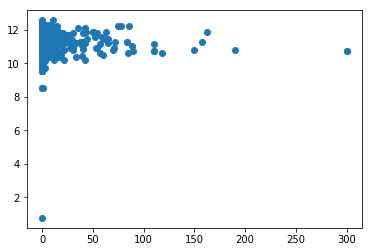

In [362]:
df_CEW_final = Multiple_Linear_Regression(df_CEW_final)

In [363]:
df_CEW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989


In [364]:
#creating training and testign dataset 
#mask = np.random.rand(len(df_CEW_final)) < 0.8
#df_train_CEW = df_CEW_final[mask]
#df_test_CEW = df_CEW_final[~mask]

In [365]:
#df_train_CEW.head()

In [366]:
#print(len(df_train_CEW))
#print(len(df_test_CEW))

In [367]:
#expr_CEW = """trap_count ~ tempf + dwpf + drct + feel"""

In [368]:
#Set up the X and y matrices
#y_train, X_train = dmatrices(expr_CEW, df_CEW_final, return_type='dataframe')
#y_test, X_test = dmatrices(expr_CEW, df_CEW_final, return_type='dataframe')

#y_train, X_train = dmatrices(expr_CEW, df_train_CEW, return_type='dataframe')
#y_test, X_test = dmatrices(expr_CEW, df_test_CEW, return_type='dataframe')

In [369]:
#X_test

In [370]:
#y_test

In [371]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
#poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [372]:
#print(poisson_training_results.summary())

In [373]:
#Make some predictions on the test data set.
#poisson_predictions = poisson_training_results.get_prediction(X_test)

In [374]:
#summary_frame() returns a pandas DataFrame
#predictions_summary_frame = poisson_predictions.summary_frame()
#print(predictions_summary_frame)

In [375]:
#predicted_counts=predictions_summary_frame['mean']
#actual_counts = y_test['trap_count']

In [376]:
#poisson_count = predictions_summary_frame['mean']

In [377]:
#poisson_count

In [378]:
#print(actual_counts)

In [379]:
#Mlot the predicted counts versus the actual counts for the test data.
#fig = plt.figure()
#fig.suptitle('Predicted versus actual CEW pest counts ')
#predicted, = plt.plot(X_test.index, poisson_count, 'go-', label='Predicted counts')
#actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
#plt.legend(handles=[predicted, actual])
#plt.show()

In [380]:
#plt.clf()
#fig = plt.figure()
#fig.suptitle('Poisson Regression Scatter plot')
#plt.scatter(x=poisson_count, y=actual_counts, marker='.')
#plt.xlabel('Poisson counts')
#plt.ylabel('Actual counts')
#plt.show()

In [381]:
#writing dataframe into csv file

In [382]:
df_CEW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989


                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 2571
Model:                            GLM   Df Residuals:                     2566
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -41041.
Date:                Thu, 07 May 2020   Deviance:                       75750.
Time:                        09:58:44   Pearson chi2:                 1.55e+05
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2900      0.042     54.923      0.000       2.208       2.372
tempf         -0.0907      0.008    -12.012      0.0

<Figure size 432x288 with 0 Axes>

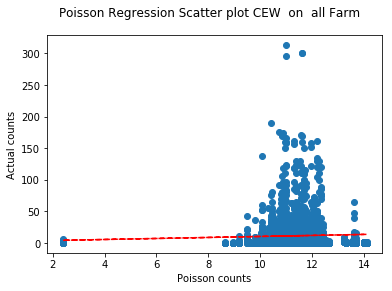

In [383]:
df_CEW_final = Poisson_Regression(df_CEW_final," CEW ", " all ")

In [384]:
#df_CEW_final['poisson_count'] = poisson_count

In [385]:
df_CEW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287


In [386]:
#writing into the csv file
df_CEW_final.to_csv("CEW_predicted_count.csv", index = False, sep = ',')

# Negative Binomial Regression - CEW

In [387]:
#print out the fitted rate vector
#print(poisson_training_results.mu)

In [388]:
#Add the λ vector as a new column called 'LAMBDA' to the Data Frame of the training data set
#df_CEW_final_NB = df_CEW_final

In [389]:
#df_CEW_final_NB.head()

In [390]:
#df_CEW_final_NB['LAMBDA'] = poisson_training_results.mu

In [391]:
#df_CEW_final_NB.head()

In [392]:
#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
#df_CEW_final_NB['AUX_OLS_DEP'] = df_CEW_final_NB.apply(lambda x: ((x['poisson_count'] - x['LAMBDA'])**2 - x['poisson_count']) / x['LAMBDA'], axis=1)



In [393]:
#df_CEW_final_NB.head()

In [394]:
#import statsmodels.formula.api as smf
#import statsmodels.api as sm

In [395]:
#ols_expr = """AUX_OLS_DEP ~ LAMBDA - 1"""

In [396]:
#fitting the OLSR model
#aux_olsr_results = smf.ols(ols_expr, df_CEW_final_NB).fit()

In [397]:
#Print the regression params
#print(abs(aux_olsr_results.params[0]))


In [398]:
#defining negative binomial regression model 
#M2_NB_CEW = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha = abs(aux_olsr_results.params[0]))).fit()


In [399]:
#print(M2_NB_CEW.summary())

In [400]:
#predictions using NB2 model
#nb2_predictions = nb2_training_results.get_prediction(X_test)
#M2_NB_CEW_pred = M2_NB_CEW.get_prediction(X_test)

In [401]:
#print out the predictions
#predictions_summary_frame = M2_NB_CEW_pred.summary_frame()
#print(predictions_summary_frame)

In [402]:
#plot the predicted counts versus the actual counts for the test data
#NB_counts=predictions_summary_frame['mean']

In [403]:
#NB_counts

In [404]:
#NB_actual_counts = y_test['trap_count']

In [405]:
#fig = plt.figure()
#fig.suptitle('Negative Binomial Regression')
#predicted, = plt.plot(X_test.index, NB_counts, 'go-', label='NB Predicted counts')
#actual, = plt.plot(X_test.index, NB_actual_counts, 'ro-', label='Actual counts')
#plt.legend(handles=[predicted, actual])
#plt.show()

In [406]:
#plt.clf()
#fig = plt.figure()
#fig.suptitle('Negative Binomial Regression Scatter plot')
#plt.scatter(x=NB_counts, y=NB_actual_counts, marker='.')
#plt.xlabel('Negative Binomial counts')
#plt.ylabel('Actual counts')
#plt.show()

In [407]:
#df_CEW_final['NB_count'] = NB_counts

In [408]:
df_CEW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287


                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 2571
Model:                            GLM   Df Residuals:                     2566
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20848.
Date:                Thu, 07 May 2020   Deviance:                       34263.
Time:                        09:58:45   Pearson chi2:                 7.77e+04
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2529      0.059     38.145      0.000       2.137       2.369
tempf         -0.1147      0.010    -11.207      0.0

<Figure size 432x288 with 0 Axes>

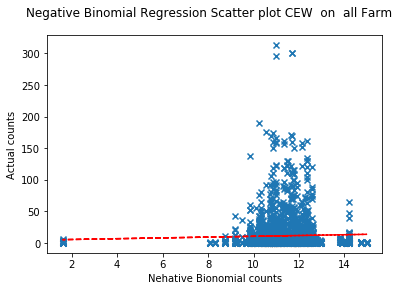

In [409]:
df_CEW_final = Negative_Binomial_Regression(df_CEW_final, " CEW ", " all ")

In [411]:
df_CEW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317


In [412]:
#df_CEW_final.drop('LAMBDA', axis=1, inplace=True)
#df_CEW_final.drop('AUX_OLS_DEP', axis=1, inplace=True)

In [413]:
df_CEW_final.head(12)

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
5,Hollis-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
6,Hollis-K,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
7,Milford-S,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
8,Antrim-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
9,Mason-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317


In [414]:
#writing into the csv file
df_CEW_final.to_csv("CEW_predicted_count.csv", index = False, sep = ',')

# Poisson and Negative Binomial Regression Based on Each Farm

In [415]:
#1 for the farm Pelham-G
df_CEW_pelham = df_CEW_final.loc[df_CEW_final['farm'] == 'Pelham-G']

#2 for the farm Pelham-G
df_CEW_LitchfieldW = df_CEW_final.loc[df_CEW_final['farm'] == 'Litchfield-W']

#3 for the farm Pelham-G
df_CEW_LitchfieldM = df_CEW_final.loc[df_CEW_final['farm'] == 'Litchfield-M']

#4 for the farm Pelham-G
df_CEW_MerrimackT = df_CEW_final.loc[df_CEW_final['farm'] == 'Merrimack-T']

#5 for the farm Pelham-G
df_CEW_HollisL = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-L']

#6 for the farm Pelham-G
df_CEW_HollisB = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-B']

#7 for the farm Pelham-G
df_CEW_HollisK = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-K']

#8 for the farm Pelham-G
df_CEW_MilfordS = df_CEW_final.loc[df_CEW_final['farm'] == 'Milford-S']

#9 for the farm Pelham-G
df_CEW_AntrimT = df_CEW_final.loc[df_CEW_final['farm'] == 'Antrim-T']

#10 for the farm Pelham-G
df_CEW_MasonB = df_CEW_final.loc[df_CEW_final['farm'] == 'Mason-B']

#11 for the farm Pelham-G
df_CEW_PeterboroughR = df_CEW_final.loc[df_CEW_final['farm'] == 'Peterborough-R']

In [416]:
df_CEW_pelham.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317
11,Pelham-G,0,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,11.033953,10.824663,10.793132
22,Pelham-G,0,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,11.528981,12.268939,12.518481
33,Pelham-G,0,2006,2006-07-10,71.830909,66.491782,59.745455,72.608255,10.756261,10.622663,10.572345
45,Pelham-G,0,2006,2006-07-17,73.200175,66.515808,101.004367,74.150786,11.687964,11.674616,11.854049


                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -821.31
Date:                Thu, 07 May 2020   Deviance:                       1433.0
Time:                        10:05:55   Pearson chi2:                 2.42e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0062      0.370     -2.719      0.007      -1.732      -0.281
tempf         -0.0256      0.040     -0.648      0.5

<Figure size 432x288 with 0 Axes>

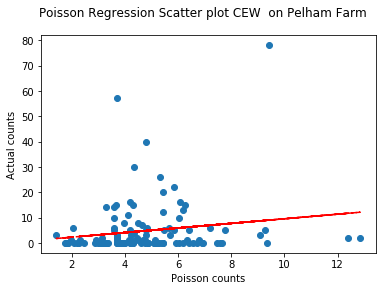

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [417]:
#1
df_CEW_pelham = Poisson_Regression(df_CEW_pelham," CEW ", "Pelham ")


                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -296.08
Date:                Thu, 07 May 2020   Deviance:                       247.76
Time:                        10:05:57   Pearson chi2:                     308.
No. Iterations:                    16   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1427      0.899     -1.271      0.204      -2.905       0.620
tempf         -0.0917      0.112     -0.819      0.4

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

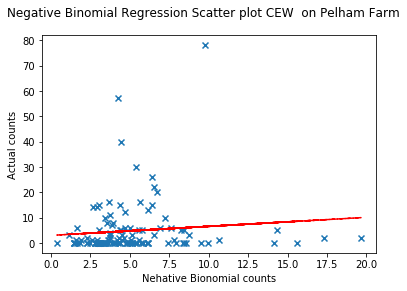

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [418]:
#1
df_CEW_pelham = Negative_Binomial_Regression(df_CEW_pelham," CEW ", "Pelham ")

In [419]:
#df_CEW_pelham

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   71
Model:                            GLM   Df Residuals:                       66
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1624.1
Date:                Thu, 07 May 2020   Deviance:                       2949.4
Time:                        10:06:02   Pearson chi2:                 3.27e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1329      0.262     31.007      0.000       7.619       8.647
tempf          0.0215      0.022      0.972      0.3

<Figure size 432x288 with 0 Axes>

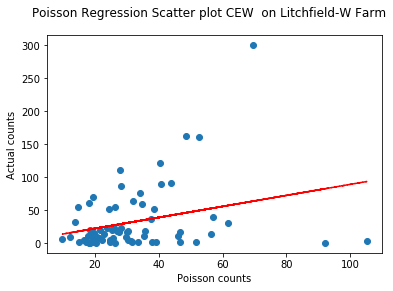

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [420]:
#2 for the farm Litchfield-W
#df_CEW_LitchfieldW = df_CEW_final.loc[df_CEW_final['farm'] == 'Litchfield-W']
df_CEW_LitchfieldW = Poisson_Regression(df_CEW_LitchfieldW ," CEW ", "Litchfield-W ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   71
Model:                            GLM   Df Residuals:                       66
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -328.36
Date:                Thu, 07 May 2020   Deviance:                       203.49
Time:                        10:06:03   Pearson chi2:                     156.
No. Iterations:                    17   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8430      1.257      7.829      0.000       7.379      12.307
tempf         -0.0086      0.062     -0.140      0.8

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

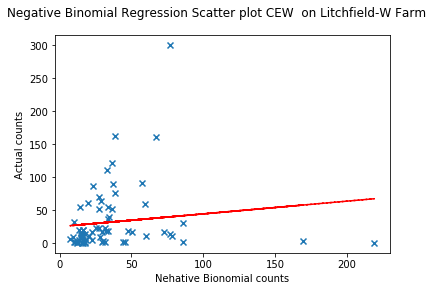

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [421]:
df_CEW_LitchfieldW = Negative_Binomial_Regression(df_CEW_LitchfieldW ," CEW ", "Litchfield-W ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  147
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2056.5
Date:                Thu, 07 May 2020   Deviance:                       3762.8
Time:                        10:06:03   Pearson chi2:                 7.16e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3816      0.181     13.123      0.000       2.026       2.737
tempf         -0.2770      0.045     -6.196      0.0

<Figure size 432x288 with 0 Axes>

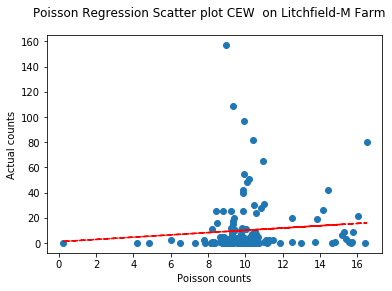

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [422]:
#3 for the farm Litchfield-M 
#df_CEW_LitchfieldM = df_CEW_final.loc[df_CEW_final['farm'] == 'Litchfield-M']
df_CEW_LitchfieldM = Poisson_Regression(df_CEW_LitchfieldM," CEW ", "Litchfield-M ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  147
Model:                            GLM   Df Residuals:                      142
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1245.5
Date:                Thu, 07 May 2020   Deviance:                       2093.2
Time:                        10:06:04   Pearson chi2:                 4.41e+03
No. Iterations:                    11   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3695      0.235     10.088      0.000       1.909       2.830
tempf         -0.3458      0.058     -5.956      0.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

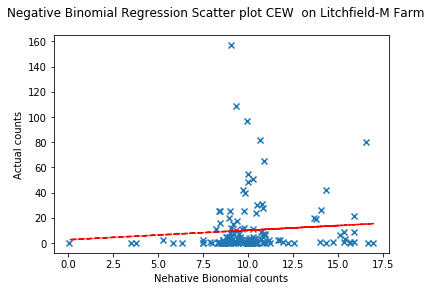

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [423]:
df_CEW_LitchfieldM = Negative_Binomial_Regression(df_CEW_LitchfieldM," CEW ", "Litchfield-M ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   57
Model:                            GLM   Df Residuals:                       52
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -261.86
Date:                Thu, 07 May 2020   Deviance:                       442.06
Time:                        10:06:05   Pearson chi2:                 1.00e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1511      1.593      1.978      0.048       0.028       6.274
tempf         -0.8531      0.300     -2.848      0.0

<Figure size 432x288 with 0 Axes>

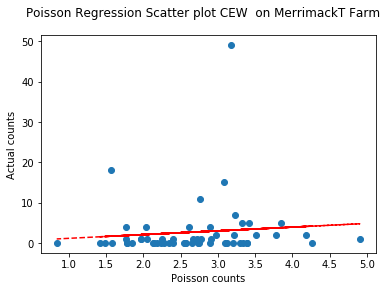

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [424]:
#4 for the farm Pelham-G
#df_CEW_MerrimackT = df_CEW_final.loc[df_CEW_final['farm'] == 'Merrimack-T']
df_CEW_MerrimackT = Poisson_Regression(df_CEW_MerrimackT," CEW ", "MerrimackT ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   57
Model:                            GLM   Df Residuals:                       52
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -110.19
Date:                Thu, 07 May 2020   Deviance:                       28.584
Time:                        10:06:07   Pearson chi2:                     41.0
No. Iterations:                    21   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2520      7.751      1.065      0.287      -6.940      23.444
tempf         -2.0531      1.420     -1.446      0.1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

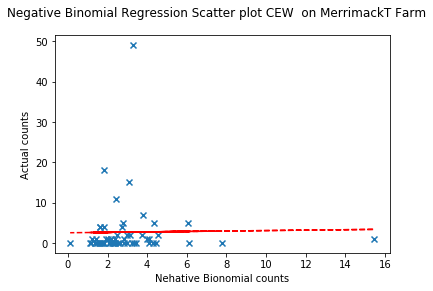

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [425]:
df_CEW_MerrimackT = Negative_Binomial_Regression(df_CEW_MerrimackT," CEW ", "MerrimackT ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  131
Model:                            GLM   Df Residuals:                      126
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1651.0
Date:                Thu, 07 May 2020   Deviance:                       2932.4
Time:                        10:06:07   Pearson chi2:                 4.81e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4252      0.176     13.742      0.000       2.079       2.771
tempf         -0.1507      0.033     -4.523      0.0

<Figure size 432x288 with 0 Axes>

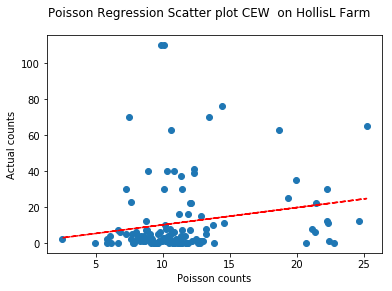

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [426]:
#5 for the farm Pelham-G
#df_CEW_HollisL = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-L']
df_CEW_HollisL = Poisson_Regression(df_CEW_HollisL," CEW ", "HollisL ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  131
Model:                            GLM   Df Residuals:                      126
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1146.4
Date:                Thu, 07 May 2020   Deviance:                       1887.0
Time:                        10:06:08   Pearson chi2:                 3.39e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4947      0.216     11.573      0.000       2.072       2.917
tempf         -0.1561      0.038     -4.149      0.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

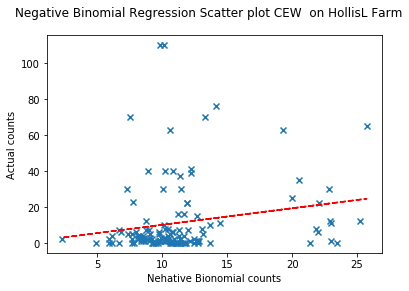

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [427]:
df_CEW_HollisL = Negative_Binomial_Regression(df_CEW_HollisL," CEW ", "HollisL ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1648.7
Date:                Thu, 07 May 2020   Deviance:                       3091.3
Time:                        10:06:09   Pearson chi2:                 4.36e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6484      0.496      7.357      0.000       2.676       4.620
tempf         -0.4368      0.089     -4.884      0.0

<Figure size 432x288 with 0 Axes>

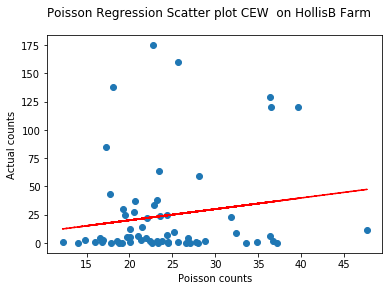

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [428]:
#6 for the farm Pelham-G
#df_CEW_HollisB = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-B']
df_CEW_HollisB = Poisson_Regression(df_CEW_HollisB," CEW ", "HollisB ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -363.47
Date:                Thu, 07 May 2020   Deviance:                       438.44
Time:                        10:06:10   Pearson chi2:                     479.
No. Iterations:                    26   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9325      1.498      4.626      0.000       3.996       9.869
tempf         -1.0371      0.266     -3.893      0.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

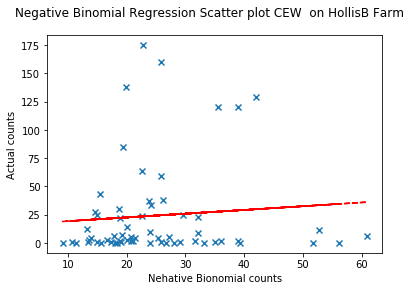

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [429]:
df_CEW_HollisB = Negative_Binomial_Regression(df_CEW_HollisB," CEW ", "HollisB ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  150
Model:                            GLM   Df Residuals:                      145
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2617.0
Date:                Thu, 07 May 2020   Deviance:                       4826.3
Time:                        10:06:10   Pearson chi2:                 8.15e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2953      0.161      8.045      0.000       0.980       1.611
tempf         -0.1764      0.033     -5.369      0.0

<Figure size 432x288 with 0 Axes>

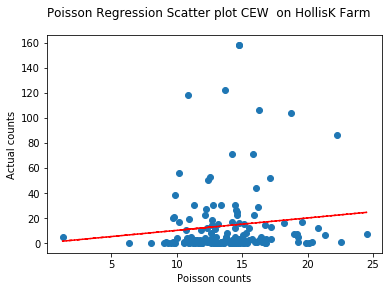

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [430]:
#7 for the farm Pelham-G
#df_CEW_HollisK = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-K']
df_CEW_HollisK = Poisson_Regression(df_CEW_HollisK," CEW ", "HollisK ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  150
Model:                            GLM   Df Residuals:                      145
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2171.7
Date:                Thu, 07 May 2020   Deviance:                       3917.8
Time:                        10:06:11   Pearson chi2:                 7.03e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3042      0.173      7.533      0.000       0.965       1.644
tempf         -0.1768      0.035     -5.099      0.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

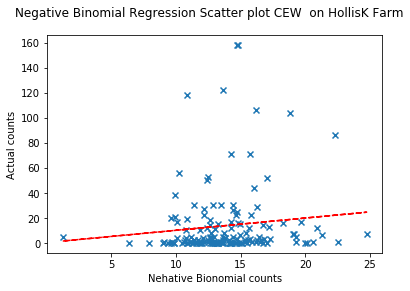

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [431]:
df_CEW_HollisK = Negative_Binomial_Regression(df_CEW_HollisK," CEW ", "HollisK ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  133
Model:                            GLM   Df Residuals:                      128
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2587.4
Date:                Thu, 07 May 2020   Deviance:                       4824.0
Time:                        10:06:12   Pearson chi2:                 9.66e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4241      0.168     20.416      0.000       3.095       3.753
tempf         -0.0154      0.027     -0.567      0.5

<Figure size 432x288 with 0 Axes>

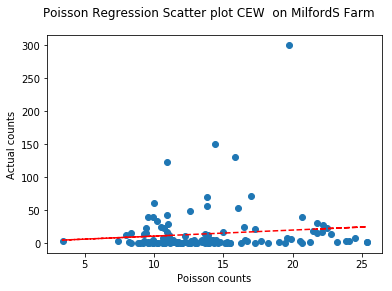

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [432]:
#8 for the farm Pelham-G
#df_CEW_MilfordS = df_CEW_final.loc[df_CEW_final['farm'] == 'Milford-S']
df_CEW_MilfordS  = Poisson_Regression(df_CEW_MilfordS ," CEW ", "MilfordS ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  133
Model:                            GLM   Df Residuals:                      128
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1444.7
Date:                Thu, 07 May 2020   Deviance:                       2495.1
Time:                        10:06:13   Pearson chi2:                 5.51e+03
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3529      0.226     14.854      0.000       2.910       3.795
tempf         -0.0205      0.033     -0.619      0.5

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

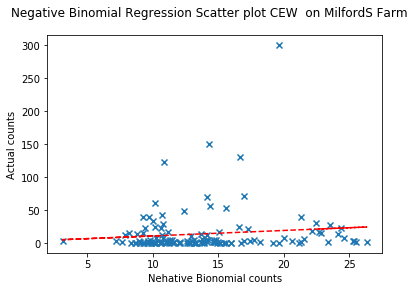

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [433]:
df_CEW_MilfordS  = Negative_Binomial_Regression(df_CEW_MilfordS ," CEW ", "MilfordS ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  142
Model:                            GLM   Df Residuals:                      137
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1251.4
Date:                Thu, 07 May 2020   Deviance:                       2179.9
Time:                        10:06:13   Pearson chi2:                 3.63e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9277      0.261      3.557      0.000       0.416       1.439
tempf         -0.0284      0.039     -0.733      0.4

<Figure size 432x288 with 0 Axes>

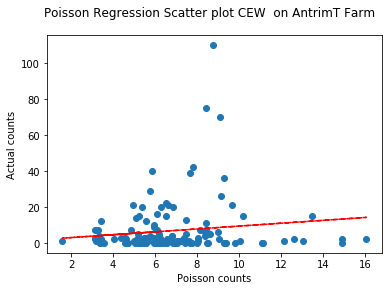

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [434]:
#9 for the farm Pelham-G
#df_CEW_AntrimT = df_CEW_final.loc[df_CEW_final['farm'] == 'Antrim-T']
df_CEW_AntrimT = Poisson_Regression(df_CEW_AntrimT," CEW ", "AntrimT ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  142
Model:                            GLM   Df Residuals:                      137
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -586.71
Date:                Thu, 07 May 2020   Deviance:                       762.84
Time:                        10:06:14   Pearson chi2:                 1.18e+03
No. Iterations:                    10   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6176      0.413      1.497      0.134      -0.191       1.426
tempf         -0.0822      0.067     -1.233      0.2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

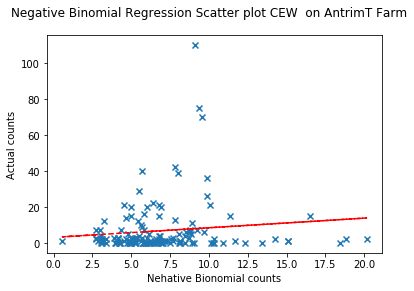

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [435]:
df_CEW_AntrimT = Negative_Binomial_Regression(df_CEW_AntrimT," CEW ", "AntrimT ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1691.4
Date:                Thu, 07 May 2020   Deviance:                       3035.8
Time:                        10:06:15   Pearson chi2:                 4.65e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1164      0.175     12.119      0.000       1.774       2.459
tempf         -0.0215      0.049     -0.434      0.6

<Figure size 432x288 with 0 Axes>

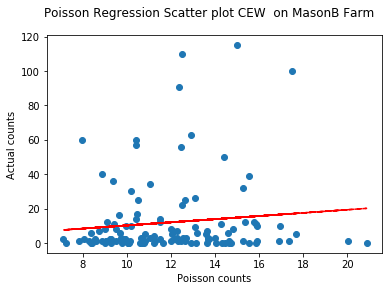

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [436]:
#10 for the farm Pelham-G
#df_CEW_MasonB = df_CEW_final.loc[df_CEW_final['farm'] == 'Mason-B']
df_CEW_MasonB = Poisson_Regression(df_CEW_MasonB," CEW ", "MasonB ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1119.0
Date:                Thu, 07 May 2020   Deviance:                       1854.8
Time:                        10:06:16   Pearson chi2:                 3.02e+03
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0936      0.219      9.580      0.000       1.665       2.522
tempf         -0.0301      0.060     -0.501      0.6

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

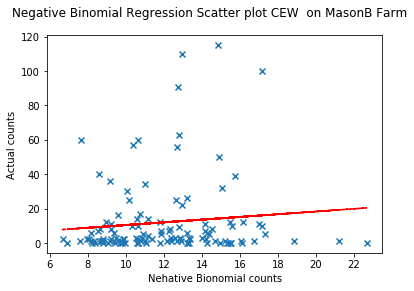

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [437]:
df_CEW_MasonB = Negative_Binomial_Regression(df_CEW_MasonB," CEW ", "MasonB ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -323.90
Date:                Thu, 07 May 2020   Deviance:                       583.82
Time:                        10:06:16   Pearson chi2:                 1.36e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5814      0.688     -5.204      0.000      -4.930      -2.233
tempf         -0.3741      0.173     -2.164      0.0

<Figure size 432x288 with 0 Axes>

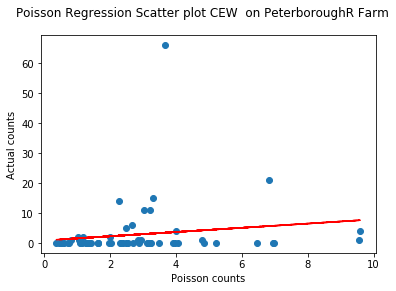

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [438]:
#11 for the farm Pelham-G
#df_CEW_PeterboroughR = df_CEW_final.loc[df_CEW_final['farm'] == 'Peterborough-R']
df_CEW_PeterboroughR  = Poisson_Regression(df_CEW_PeterboroughR ," CEW ", "PeterboroughR ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -90.450
Date:                Thu, 07 May 2020   Deviance:                       41.086
Time:                        10:06:17   Pearson chi2:                     52.5
No. Iterations:                    16   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.0995      2.854     -3.538      0.000     -15.694      -4.505
tempf         -1.3440      0.682     -1.970      0.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

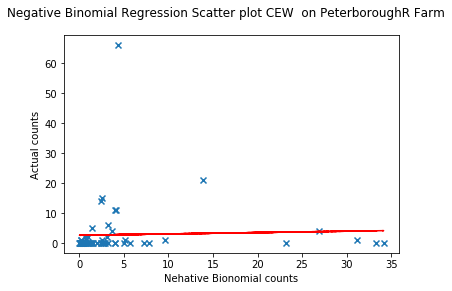

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [439]:
df_CEW_PeterboroughR  = Negative_Binomial_Regression(df_CEW_PeterboroughR ," CEW ", "PeterboroughR ")

In [440]:
df_CEW_pelham.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,3.176978,3.023526
11,Pelham-G,0,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,11.033953,10.824663,10.793132,3.996585,3.594057
22,Pelham-G,0,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,11.528981,12.268939,12.518481,6.933632,8.571983
33,Pelham-G,0,2006,2006-07-10,71.830909,66.491782,59.745455,72.608255,10.756261,10.622663,10.572345,3.089388,2.768934
45,Pelham-G,0,2006,2006-07-17,73.200175,66.515808,101.004367,74.150786,11.687964,11.674616,11.854049,5.179942,5.008702


In [441]:
df_CEW_final['poisson_count_farm'] = 0
df_CEW_final['NB_count_farm'] = 0

In [442]:
df_CEW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0,0
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0,0
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0,0
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0,0
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0,0


In [443]:
#1
df_CEW_final.loc[df_CEW_final.farm == 'Pelham-G', ['poisson_count_farm']] = df_CEW_pelham.loc[df_CEW_pelham.farm == 'Pelham-G', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Pelham-G', ['NB_count_farm']] = df_CEW_pelham.loc[df_CEW_pelham.farm == 'Pelham-G', ['NB_count_farm']]


In [444]:
df_CEW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,3.176978,3.023526
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000


In [445]:
df_CEW_LitchfieldW.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,26.307240,15.291470
12,Litchfield-W,0,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,11.033953,10.824663,10.793132,18.207249,11.828533
23,Litchfield-W,3,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,11.528981,12.268939,12.518481,31.192923,30.508435
34,Litchfield-W,1,2006,2006-07-10,71.830909,66.491782,59.745455,72.608255,10.756261,10.622663,10.572345,19.725128,10.476583
46,Litchfield-W,1,2006,2006-07-17,73.200175,66.515808,101.004367,74.150786,11.687964,11.674616,11.854049,15.029908,10.268948


In [446]:
#2
df_CEW_final.loc[df_CEW_final.farm == 'Litchfield-W', ['poisson_count_farm']] = df_CEW_LitchfieldW.loc[df_CEW_LitchfieldW.farm == 'Litchfield-W', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Litchfield-W', ['NB_count_farm']] = df_CEW_LitchfieldW.loc[df_CEW_LitchfieldW.farm == 'Litchfield-W', ['NB_count_farm']]



In [447]:
df_CEW_final

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,3.176978,3.023526
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,26.307240,15.291470
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
5,Hollis-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
6,Hollis-K,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
7,Milford-S,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
8,Antrim-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
9,Mason-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000


In [448]:
#3
#df_CEW_final['poisson_count_farm'] = df_CEW_LitchfieldM['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Litchfield-M', ['poisson_count_farm']] = df_CEW_LitchfieldM.loc[df_CEW_LitchfieldM.farm == 'Litchfield-M', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Litchfield-M', ['NB_count']] = df_CEW_LitchfieldM.loc[df_CEW_LitchfieldM.farm == 'Litchfield-M', ['NB_count']]


In [449]:
df_CEW_final.head(15)

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,3.176978,3.023526
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,26.307240,15.291470
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,9.087069,0.000000
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
5,Hollis-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
6,Hollis-K,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
7,Milford-S,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
8,Antrim-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000
9,Mason-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10.459989,10.502287,10.398317,0.000000,0.000000


In [450]:
#4
#df_CEW_final['poisson_count_farm'] = df_CEW_MerrimackT['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Merrimack-T', ['poisson_count_farm']] = df_CEW_MerrimackT.loc[df_CEW_MerrimackT.farm == 'Merrimack-T', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Merrimack-T', ['NB_count_farm']] = df_CEW_MerrimackT.loc[df_CEW_MerrimackT.farm == 'Merrimack-T', ['NB_count_farm']]


In [451]:
#5
#df_CEW_final['poisson_count_farm'] = df_CEW_HollisL['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Hollis-L', ['poisson_count_farm']] = df_CEW_HollisL.loc[df_CEW_HollisL.farm == 'Hollis-L', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Hollis-L', ['NB_count_farm']] = df_CEW_HollisL.loc[df_CEW_HollisL.farm == 'Hollis-L', ['NB_count_farm']]


In [452]:
#6
#df_CEW_final['poisson_count_farm'] = df_CEW_HollisB['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Hollis-B', ['poisson_count_farm']] = df_CEW_HollisB.loc[df_CEW_HollisB.farm == 'Hollis-B', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Hollis-B', ['NB_count_farm']] = df_CEW_HollisB.loc[df_CEW_HollisB.farm == 'Hollis-B', ['NB_count_farm']]


In [453]:
#7
#df_CEW_final['poisson_count_farm'] = df_CEW_HollisK['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Hollis-K', ['poisson_count_farm']] = df_CEW_HollisK.loc[df_CEW_HollisK.farm == 'Hollis-K', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Hollis-K', ['NB_count_farm']] = df_CEW_HollisK.loc[df_CEW_HollisK.farm == 'Hollis-K', ['NB_count_farm']]


In [454]:
#8
#df_CEW_final['poisson_count_farm'] = df_CEW_MilfordS['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Milford-S', ['poisson_count_farm']] = df_CEW_MilfordS.loc[df_CEW_MilfordS.farm == 'Milford-S', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Milford-S', ['NB_count_farm']] = df_CEW_MilfordS.loc[df_CEW_MilfordS.farm == 'Milford-S', ['NB_count_farm']]


In [455]:
#9
#df_CEW_final['poisson_count_farm'] = df_CEW_AntrimT['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Antrim-T', ['poisson_count_farm']] = df_CEW_AntrimT.loc[df_CEW_AntrimT.farm == 'Antrim-T', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Antrim-T', ['NB_count_farm']] = df_CEW_AntrimT.loc[df_CEW_AntrimT.farm == 'Antrim-T', ['NB_count_farm']]


In [456]:
#10
#df_CEW_final['poisson_count_farm'] = df_CEW_MasonB['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Mason-B', ['poisson_count_farm']] = df_CEW_MasonB.loc[df_CEW_MasonB.farm == 'Mason-B', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Mason-B', ['NB_count_farm']] = df_CEW_MasonB.loc[df_CEW_MasonB.farm == 'Mason-B', ['NB_count_farm']]


In [457]:
#11
#df_CEW_final['poisson_count_farm'] = df_CEW_PeterboroughR['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Peterborough-R', ['poisson_count_farm']] = df_CEW_PeterboroughR.loc[df_CEW_PeterboroughR.farm == 'Peterborough-R', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Peterborough-R', ['NB_count_farm']] = df_CEW_PeterboroughR.loc[df_CEW_PeterboroughR.farm == 'Peterborough-R', ['NB_count_farm']]


In [458]:
df_CEW_final['regression_count'] = df_CEW_final['regression_count'].apply(np.int64)
df_CEW_final['poisson_count'] = df_CEW_final['poisson_count'].apply(np.int64)
df_CEW_final['NB_count'] = df_CEW_final['NB_count'].apply(np.int64)
df_CEW_final['poisson_count_farm'] = df_CEW_final['poisson_count_farm'].apply(np.int64)

df_CEW_final['NB_count_farm'] = df_CEW_final['NB_count_farm'].apply(np.int64)


In [459]:
df_CEW_final

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,3,3
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,26,15
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,9,0
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,1,1
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,8,8
5,Hollis-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,13,11
6,Hollis-K,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,10,10
7,Milford-S,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,11,10
8,Antrim-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,6,5
9,Mason-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,8,8


In [462]:
#writing into the csv file
df_CEW_final.to_csv("CEW_predicted_count.csv", index = False, sep = ',')

# selecting weather dataframe within the date range - ECB Pest

In [463]:
print(search_ecb_STdate)
print(search_ecb_ENDdate)

2006-06-19 00:00:00
2018-10-15 00:00:00


In [464]:
df_equation_ECB = df_equation.loc[(df_equation['valid'] >= search_ecb_STdate) & (df_equation['valid'] <= search_ecb_ENDdate), :]

In [465]:
#need to get all the columns from here and sum up fro every week 
#select date and each column, and find the average for each column
df_tempf_ECB = df_equation_ECB[['tmpf','dwpf', 'drct','feel','valid']]
df_tempf_ECB["tmpf"] = df_tempf_ECB["tmpf"].fillna(0)
df_tempf_ECB["dwpf"] = df_tempf_ECB["dwpf"].fillna(0)
df_tempf_ECB["drct"] = df_tempf_ECB["drct"].fillna(0)
df_tempf_ECB["feel"] = df_tempf_ECB["feel"].fillna(0)

In [466]:
#calling getweekly_temperature
ECB_weather_data_dic = {}
getweekly_temperature(df_tempf_ECB,ECB_weather_data_dic)

total temperature index  642
total weeks:  47922


In [467]:
df_ECB_weather = pd.DataFrame(ECB_weather_data_dic)

In [468]:
df_ECB['date'] = df_ECB['date'].dt.date

In [469]:
#combining weather data and pest count data based on the date -----
#creating data frame needed for equation
df_ECB_weather['date'] = pd.to_datetime(df_ECB_weather['date'])
df_ECB_weather['date'] = df_ECB_weather['date'].dt.date
df_ECB_final = df_ECB.merge(df_ECB_weather, on='date')

In [470]:
df_ECB_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel
0,Litchfield-W,16,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
1,Hollis-B,7,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
2,Mason-B,11,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
3,Litchfield-W,25,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347
4,Hollis-B,31,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347


# predicting trap counts :::: ECB pest

In [471]:
#creating training and testign dataset 
#mask_ecb = np.random.rand(len(df_ECB_final)) < 0.8
#df_train_ECB = df_ECB_final[mask_ecb]
#df_test_ECB = df_ECB_final[~mask_ecb]

In [472]:
#expr_ECB = """trap_count ~ tempf + dwpf + drct + feel"""

In [473]:
#Set up the X and y matrices
#y_train_ecb, X_train_ecb = dmatrices(expr_ECB, df_ECB_final, return_type='dataframe')
#y_test_ecb, X_test_ecb = dmatrices(expr_ECB, df_ECB_final, return_type='dataframe')

In [474]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
#poisson_training_results_ecb = sm.GLM(y_train_ecb, X_train_ecb, family=sm.families.Poisson()).fit()

In [475]:
#print(poisson_training_results_ecb.summary())

In [476]:
#Make some predictions on the test data set.
#poisson_predictions_ecb = poisson_training_results_ecb.get_prediction(X_test_ecb)

In [477]:
#.summary_frame() returns a pandas DataFrame
#predictions_summary_frame_ecb = poisson_predictions_ecb.summary_frame()
#print(predictions_summary_frame_ecb)

In [478]:
#predicted_counts_ecb=predictions_summary_frame_ecb['mean']
#actual_counts_ecb = y_test_ecb['trap_count']

In [479]:
#print(predicted_counts_ecb)

In [480]:
#print(actual_counts_ecb)

In [481]:
#Mlot the predicted counts versus the actual counts for the test data.
#fig = plt.figure()
#fig.suptitle('Predicted versus actual ECB pest counts ')
#predicted, = plt.plot(X_test_ecb.index, predicted_counts_ecb, 'go-', label='Predicted counts')
#actual, = plt.plot(X_test_ecb.index, actual_counts_ecb, 'ro-', label='Actual counts')
#plt.legend(handles=[predicted, actual])
#plt.show()

In [483]:
#df_ECB_final['predicted_counts_ecb'] = predicted_counts_ecb

Intercept:  3.3808220267663303
Coeffecients  [ 0.04189007  0.04614086 -0.00587125 -0.07856854]
(804,)
----------- Linear Regression Evaluations------------
Mean Absolute Error (MAE):  4.021307385460009
Mean Squared Eror (MSE):  61.86105644875795
Root Mean Squared Eror (RMSE):  7.865180001039897


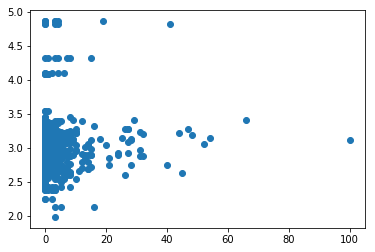

In [484]:
df_ECB_final = Multiple_Linear_Regression(df_ECB_final)

In [164]:
#writing into the csv file
df_ECB_final.to_csv("ECB_predicted_count.csv", index = False, sep = ',')

# selecting weather dataframe within the date range - FAW Pest

In [165]:
print(search_faw_STdate)
print(search_faw_ENDdate)

2006-06-19 00:00:00
2018-10-15 00:00:00


In [166]:
df_equation_FAW = df_equation.loc[(df_equation['valid'] >= search_faw_STdate) & (df_equation['valid'] <= search_faw_ENDdate), :]

In [167]:
#need to get all the columns from here and sum up fro every week 
#select date and each column, and find the average for each column
df_tempf_FAW = df_equation_FAW[['tmpf','dwpf', 'drct','feel','valid']]
df_tempf_FAW["tmpf"] = df_tempf_FAW["tmpf"].fillna(0)
df_tempf_FAW["dwpf"] = df_tempf_FAW["dwpf"].fillna(0)
df_tempf_FAW["drct"] = df_tempf_FAW["drct"].fillna(0)
df_tempf_FAW["feel"] = df_tempf_FAW["feel"].fillna(0)

In [168]:
#calling getweekly_temperature
FAW_weather_data_dic = {}
getweekly_temperature(df_tempf_FAW,FAW_weather_data_dic)

total temperature index  642
total weeks:  47922


In [169]:
df_FAW_weather = pd.DataFrame(FAW_weather_data_dic)

In [170]:
#convert orginal faw date into correct dataframe date
df_FAW['date'] = df_FAW['date'].dt.date

In [171]:
#combining weather data and pest count data based on the date -----
#creating data frame needed for equation
df_FAW_weather['date'] = pd.to_datetime(df_FAW_weather['date'])
df_FAW_weather['date'] = df_FAW_weather['date'].dt.date
df_FAW_final = df_FAW.merge(df_FAW_weather, on='date')

In [172]:
df_FAW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
4,Hollis-L,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399


# predicting trap counts :::: FAW pest

In [173]:
#creating training and testign dataset 
mask_faw = np.random.rand(len(df_FAW_final)) < 0.8
df_train_FAW = df_FAW_final[mask_faw]
df_test_FAW = df_FAW_final[~mask_faw]

In [174]:
expr_FAW = """trap_count ~ tempf + dwpf + drct + feel"""

In [175]:
#Set up the X and y matrices
y_train_faw, X_train_faw = dmatrices(expr_FAW, df_FAW_final, return_type='dataframe')
y_test_faw, X_test_faw = dmatrices(expr_FAW, df_FAW_final, return_type='dataframe')

In [176]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results_faw = sm.GLM(y_train_faw, X_train_faw, family=sm.families.Poisson()).fit()

In [177]:
print(poisson_training_results_faw.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 2634
Model:                            GLM   Df Residuals:                     2629
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13336.
Date:                Wed, 06 May 2020   Deviance:                       23704.
Time:                        20:41:59   Pearson chi2:                 7.29e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0710      0.084     12.699      0.000       0.906       1.236
tempf          0.0774      0.011      7.154      0.0

In [178]:
#Make some predictions on the test data set.
poisson_predictions_faw = poisson_training_results_faw.get_prediction(X_test_faw)

In [179]:
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame_faw = poisson_predictions_faw.summary_frame()
print(predictions_summary_frame_faw)

          mean   mean_se  mean_ci_lower  mean_ci_upper
0     1.901839  0.048888       1.808393       2.000113
1     1.901839  0.048888       1.808393       2.000113
2     1.901839  0.048888       1.808393       2.000113
3     1.901839  0.048888       1.808393       2.000113
4     1.901839  0.048888       1.808393       2.000113
5     1.901839  0.048888       1.808393       2.000113
6     1.901839  0.048888       1.808393       2.000113
7     1.901839  0.048888       1.808393       2.000113
8     1.901839  0.048888       1.808393       2.000113
9     1.901839  0.048888       1.808393       2.000113
10    1.901839  0.048888       1.808393       2.000113
11    1.681121  0.038086       1.608107       1.757450
12    1.681121  0.038086       1.608107       1.757450
13    1.681121  0.038086       1.608107       1.757450
14    1.681121  0.038086       1.608107       1.757450
15    1.681121  0.038086       1.608107       1.757450
16    1.681121  0.038086       1.608107       1.757450
17    1.68

In [180]:
predicted_counts_faw=predictions_summary_frame_faw['mean']
actual_counts_faw = y_test_faw['trap_count']

In [181]:
print(predicted_counts_faw)

0       1.901839
1       1.901839
2       1.901839
3       1.901839
4       1.901839
5       1.901839
6       1.901839
7       1.901839
8       1.901839
9       1.901839
10      1.901839
11      1.681121
12      1.681121
13      1.681121
14      1.681121
15      1.681121
16      1.681121
17      1.681121
18      1.681121
19      1.681121
20      1.681121
21      1.681121
22      3.362671
23      3.362671
24      3.362671
25      3.362671
26      3.362671
27      3.362671
28      3.362671
29      3.362671
          ...   
2604    2.568579
2605    2.568579
2606    2.566849
2607    2.566849
2608    2.566849
2609    2.566849
2610    2.566849
2611    2.566849
2612    2.566849
2613    2.566849
2614    2.566849
2615    2.566849
2616    2.566849
2617    2.566849
2618    2.566849
2619    2.566849
2620    2.566849
2621    2.566849
2622    2.566849
2623    2.566849
2624    2.479989
2625    2.479989
2626    2.479989
2627    2.479989
2628    2.479989
2629    2.479989
2630    2.479989
2631    2.4799

In [182]:
print(actual_counts_faw)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
        ... 
2604     1.0
2605     0.0
2606     5.0
2607    16.0
2608    32.0
2609     0.0
2610     2.0
2611     0.0
2612     0.0
2613     2.0
2614    22.0
2615    10.0
2616     0.0
2617     0.0
2618     0.0
2619     1.0
2620     2.0
2621     0.0
2622     1.0
2623     0.0
2624     0.0
2625     2.0
2626     0.0
2627     0.0
2628     0.0
2629     2.0
2630     0.0
2631     2.0
2632     0.0
2633     0.0
Name: trap_count, Length: 2634, dtype: float64


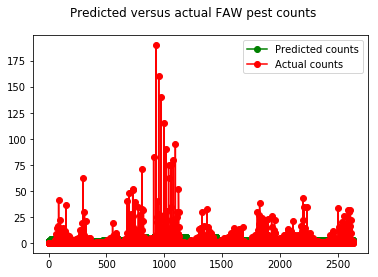

In [183]:
#Mlot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual FAW pest counts ')
predicted, = plt.plot(X_test_faw.index, predicted_counts_faw, 'go-', label='Predicted counts')
actual, = plt.plot(X_test_faw.index, actual_counts_faw, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [184]:
df_FAW_final['predicted_counts_faw'] = predicted_counts_faw

In [185]:
#writing into the csv file
df_FAW_final.to_csv("FAW_predicted_count.csv", index = False, sep = ',')